In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)


## Calculating new values

In [45]:
calc_df = mc.updated_df(df, mc.measures_list, mc.errors_list)


In [46]:
#calc_df.to_csv('../../Data/ALL_TUBE_PIPE_calc.csv')

## Scaling values

In [47]:
scaled_df = mc.scale_general(calc_df, MinMaxScaler())[0]

## Selecting sub samples

In [48]:
tube_scaled, pipe_scaled, tube_wo_blind_scaled, tube_blind_scaled = mc.get_subsample_df(scaled_df)

In [50]:
mean_feat = tube_scaled.loc[:, mc.feat_mean]
std_feat = tube_scaled.loc[:, mc.feat_stds]

# get PCA

In [52]:
def get_PCA(df, df_std):
    col_vector = df.columns
    pca = PCA(n_components=0.9, svd_solver='full')
    pca = pca.fit(df)
    xvector = pca.components_[0] 
    yvector = pca.components_[1]
    
    xs = pca.transform(df)[:,0] 
    ys = pca.transform(df)[:,1]
    
    df['PC1'] = xs
    df['PC2'] = ys
    df['stdPC'] = pca.transform(df_std)[:,0]
    vector = pd.DataFrame([xvector*max(xs), yvector*max(ys)], columns = col_vector, index=['x_vec', 'y_vec']).T
    
    return pca, df, vector

In [53]:
pca_tube = get_PCA(mean_feat, std_feat)

In [54]:
pca = pca_tube[0]
df_pca = pca_tube[1]

Text(0.5, 1.0, 'Tubes')

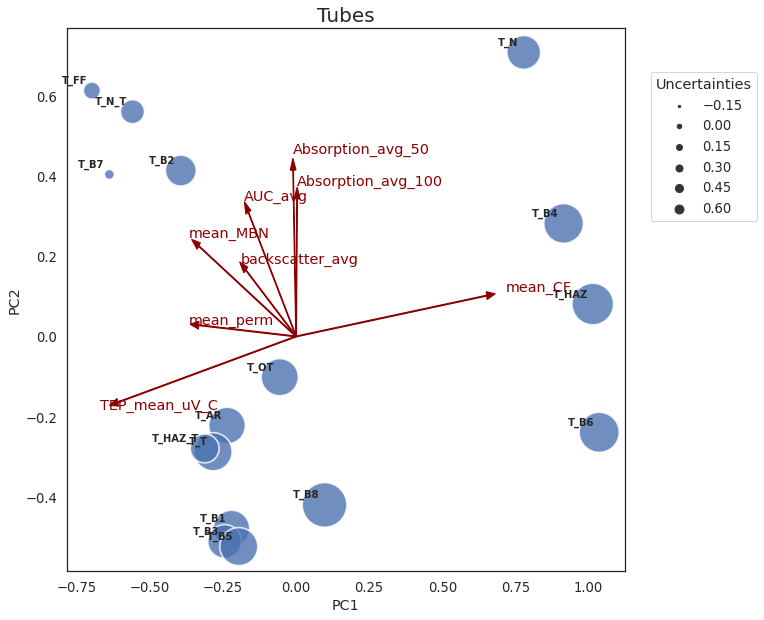

In [61]:
ax, fig = plt.subplots(figsize=(10,10))
g = sns.scatterplot(x= 'PC1', y='PC2', size='stdPC', data=pca_tube[1], sizes=(100,2000), alpha=0.8)

for i, x, y in zip(pca_tube[1].index, pca_tube[1]['PC1'], pca_tube[1]['PC2']):
    plt.annotate(i, (x, y), xytext=(-5, 5),
                 textcoords = 'offset points',
                 va='bottom', 
                 ha='right',
                 fontsize=10,
                fontweight='semibold')
for i in range(len(pca_tube[2])):
    plt.arrow(0, 0, pca_tube[2].iloc[i,0], pca_tube[2].iloc[i,1],
                  color='darkred', width=0.0025, head_width=0.02)
    plt.text(pca_tube[2].iloc[i,0]*1.1, pca_tube[2].iloc[i,1]*1.1,
                 pca_tube[2].index[i], color='darkred')

plt.legend(loc= 'best', bbox_to_anchor=(1.25, 0.93), markerscale=0.2, title='Uncertainties')
plt.title('Tubes', fontsize=20)

(0.0, 6.0)

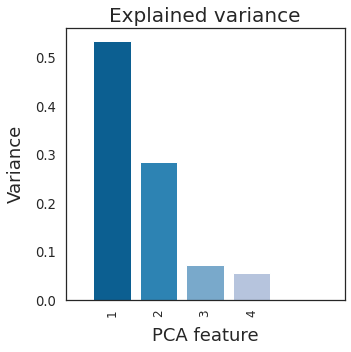

In [57]:
feat = range(1, pca.n_components_ + 1)
sns.set_theme(style='white', font_scale=1.2)
plt.figure(figsize=(5,5))
plt.bar(feat, pca.explained_variance_ratio_, color=sns.color_palette('PuBu_r', 5, desat=0.9))
plt.xticks(feat, rotation=90, fontsize=12)
plt.ylabel('Variance', fontsize=18, labelpad=10)
plt.xlabel('PCA feature', fontsize=18, labelpad=10)
plt.title('Explained variance', fontsize=20)
plt.xlim(0, 6)